In [15]:
import os
from os.path import join as opj
from pl_bolts.models.autoencoders import VAE
from utils.callbacks import WandbImagesVAE

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint


from torch import distributions as D
from torch.nn import functional as F
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [2]:
## little modification to the original VAE class

class VAE_light(VAE):
    
    def step(self, batch, batch_idx):
        x = batch
        z, x_hat, p, q = self._run_step(x)

        recon_loss = F.mse_loss(x_hat, x, reduction="mean")

        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

In [3]:

latent_dim=1024
input_dim=(3,128,128)


config={"dataset":"celebA", "type":"VAE_light",}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim
model=VAE_light(input_height=128,latent_dim=512)

In [4]:
summary(model,(3,128,128),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
     EncoderBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [5]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=30
BS=128
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


## Dataloaders

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)/255.
        return image

In [7]:
transforms=Compose([
 Resize((128,128)),
])



In [8]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))
val_len=int(0.1*len(imagePaths))
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [9]:
train_dataset=ImageDataset(train_imgs,transform=transforms)
val_dataset=ImageDataset(val_imgs,transform=transforms)
test_dataset=ImageDataset(test_imgs,transform=transforms)

train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BS, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=BS, shuffle=True)


## Train Loop

In [10]:
base_path="models/vae_light"
os.makedirs(base_path,exist_ok=True)

In [11]:
checkpoint_callback = ModelCheckpoint(dirpath=base_path)

In [12]:
wandb_logger=WandbLogger(project="NeuroGEN_Pytorch")

callbacks=[
    #WandbImagesVAE(val_dataloader,target_shape=(3,128,128)),
    checkpoint_callback,
]

In [13]:
trainer=pl.Trainer(gpus=[0],max_epochs=EPOCHS,callbacks=callbacks,logger=wandb_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [29]:
trainer.fit(model,train_dataloader,val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 10.7 M
2 | fc_mu   | Linear        | 262 K 
3 | fc_var  | Linear        | 262 K 
------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.668    Total estimated model params size (MB)
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/matteo/NeuroGEN/NeuroGEN_Pytorch/models/vae_light exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 47.54 GiB total capacity; 43.25 GiB already allocated; 596.88 MiB free; 43.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
path="models/vae_light"
os.makedirs(path,exist_ok=True)
torch.save(model.state_dict(), opj(path,"vae_light_resnet18.pt"))

In [18]:
x=next(iter(test_dataloader))

In [20]:
y=model(x.to(model.device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


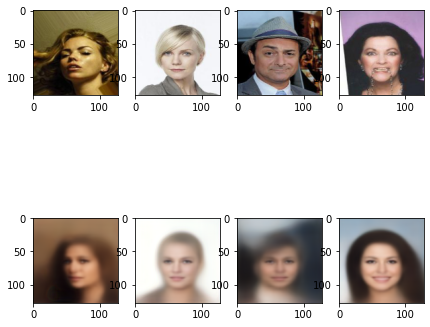

In [28]:
fig,axs=plt.subplots(2,4,figsize=(7,7))

axs[0,0].imshow(x[0].cpu().detach().permute(1,2,0).numpy())
axs[1,0].imshow(y[0].cpu().detach().permute(1,2,0).numpy())

axs[0,1].imshow(x[1].cpu().detach().permute(1,2,0).numpy())
axs[1,1].imshow(y[1].cpu().detach().permute(1,2,0).numpy())

axs[0,2].imshow(x[2].cpu().detach().permute(1,2,0).numpy())
axs[1,2].imshow(y[2].cpu().detach().permute(1,2,0).numpy())

axs[0,3].imshow(x[3].cpu().detach().permute(1,2,0).numpy())
axs[1,3].imshow(y[3].cpu().detach().permute(1,2,0).numpy())
